# IC348 Brown Dwarf selection

The goal: identify brown dwarfs in IC348 through an embarrassingly simple color-magnitude cut, and generate some of their lightcurves.


In [6]:
# imports

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table


In [7]:
# load some data

dat = Table.read('WSERV8_results6_23_50_28_30335.fits', format='fits')

mist_filename = "MIST_iso_6Myr.iso.cmd"
mist_isochrone = Table.read(mist_filename, format = 'ascii', header_start=12)
lowmass_table = mist_isochrone[mist_isochrone['star_mass'] < 3]

In [14]:
# Let's set up the data here.

# this is the so-called error correction of Hodgkin 2009, which makes the 
# error bar estimates more grounded in reality (they are otherwise unrealistically
# low for bright stars) — there's a 2% (0.02 mag) noise floor in practice that 
# is not captured in the pipeline-produced error estimates.
dat['JAPERMAG3ERR'] = (1.082 * dat['JAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['HAPERMAG3ERR'] = (1.082 * dat['HAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['KAPERMAG3ERR'] = (1.082 * dat['KAPERMAG3ERR']**2 + 0.021**2)**0.5

df = dat.to_pandas() 

# a first cleaning, to remove the `empty`-flagged 

skimmed_df = df[
    (df['JAPERMAG3'] > 0) &
    (df['HAPERMAG3'] > 0) &
    (df['KAPERMAG3'] > 0) 
]

df_groupby = skimmed_df.groupby('SOURCEID')
df_maxes = df_groupby.aggregate(np.nanmax)
df_mins = df_groupby.aggregate(np.nanmin)
df_medians = df_groupby.aggregate(np.nanmedian)
df_counts = df_groupby['JAPERMAG3'].aggregate('count')

index_selection = (
    (df_maxes['JPPERRBITS'] == 0) & 
    (df_maxes['HPPERRBITS'] == 0) & 
    (df_maxes['KPPERRBITS'] == 0) &
    (df_counts > 60) & 
    (df_counts < 130) &
    (df_medians['JAPERMAG3'] > 10) & 
    (df_medians['HAPERMAG3'] > 10) & 
    (df_medians['KAPERMAG3'] > 10) &
    (df_medians['JAPERMAG3'] < 20) & 
    (df_medians['HAPERMAG3'] < 19) & 
    (df_medians['KAPERMAG3'] < 19) &
    (df_medians['PSTAR'] > 0.9) 
#    ((df_medians['MERGEDCLASS'] == -1) | (df_medians['MERGEDCLASS'] == -2))
)
print(np.sum(index_selection))
# medians: 6532
# mins/maxes: 6530


good_indices = index_selection[index_selection==True]
# good_indices
df_pure = skimmed_df[(np.in1d(skimmed_df['SOURCEID'], good_indices.index)) & (skimmed_df['PSTAR'] > 0.9)]

df_pure_groupby = df_pure.groupby('SOURCEID')
# df_pure_means = df_pure_groupby.apply(np.mean)
df_pure_maxes = df_pure_groupby.aggregate(np.nanmax)
df_pure_mins = df_pure_groupby.aggregate(np.nanmin)
df_pure_medians = df_pure_groupby.aggregate(np.nanmedian)
df_pure_counts = df_pure_groupby['JAPERMAG3'].aggregate('count')


6532


In [16]:
# calculate variability indices
%run stetson_2020.py

df_pure_stetson = df_pure_groupby.apply(threeband_stetson_pandas)

In [17]:
# identify variable stars

strong_variable_indices = ((df_pure_stetson > 2) & (df_pure_counts > 60)) # is the `counts` bit necessary??
strong_variables = df_pure_stetson.index[strong_variable_indices]
strong_variables_df = df_pure[np.in1d(df_pure['SOURCEID'], strong_variables)]

variable_means = strong_variables_df.groupby("SOURCEID").apply(np.mean)
variable_means['Stetson'] = df_pure_stetson


In [71]:
# What are brown dwarf JHK mags here?
# Johanna writes: (in email from 21 July, 11:32AM)
# Apparent 2MASS mags:
# 14.687525162024361 14.12252516202436 13.84952516202436
J_BDlimit = 14.687525162024361
H_BDlimit = 14.12252516202436
K_BDlimit = 13.84952516202436
HmK_BDlimit = H_BDlimit-K_BDlimit

# What does A_V=1 correspond to? (see Rieke & Lebofsky 1985)
A_K = 0.112
A_H = 0.175
E_HK = A_H - A_K
print(A_K, E_HK)

print(K_BDlimit, HmK_BDlimit)

# solving for y=mx+b
slope = A_K/E_HK
y_intercept = K_BDlimit - slope*HmK_BDlimit
print(slope, y_intercept)

0.112 0.06299999999999999
13.84952516202436 0.2729999999999997
1.7777777777777781 13.364191828691027


(18.3, 7.832383105251938)

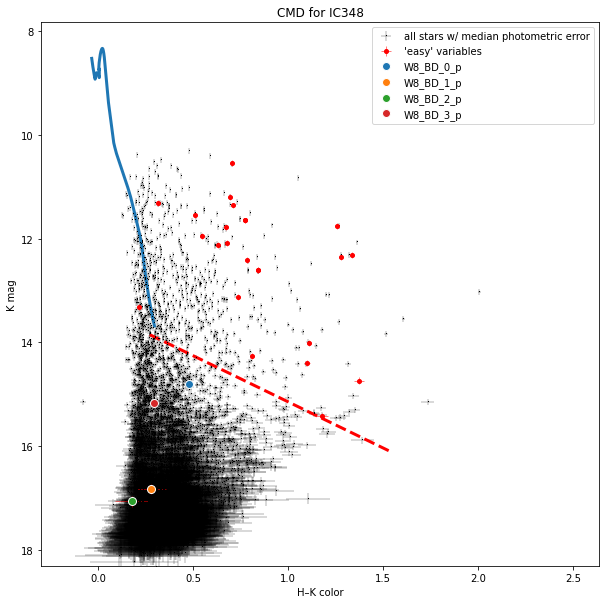

In [98]:
# first subgoal: get the CMD plot up asap.

# here's the plot:

# I am going to plot a color-magnitude diagram. K vs H-K.

#plt.plot(df_medians['RA'], df_medians['DEC'], 'k,', alpha=0.3)
#plt.plot(variable_means['RA'], variable_means['DEC'], 'r.')

fig = plt.figure(figsize=(10, 10))

plt.plot(
    lowmass_table['UKIDSS_H'] - lowmass_table['UKIDSS_K'], 
    lowmass_table['UKIDSS_K'] + distance_modulus,
    'C0',
    lw=3
)

k = df_pure_medians['KAPERMAG3']
kerr = df_pure_medians['KAPERMAG3ERR']
hmk = df_pure_medians['HMKPNT']
hmkerr = df_pure_medians['HMKPNTERR']

v_k = variable_means['KAPERMAG3']
v_kerr = variable_means['KAPERMAG3ERR']
v_hmk = variable_means['HMKPNT']
v_hmkerr = variable_means['HMKPNTERR']


# plt.plot(hmk, k, 'k,')
plt.errorbar(hmk, k, yerr=kerr, xerr=hmkerr, fmt='k,', elinewidth=0.3, label='all stars w/ median photometric error')
plt.errorbar(v_hmk, v_k, yerr=v_kerr, xerr=v_hmkerr, fmt='r.', ms=8, elinewidth=0.5, label="'easy' variables")
ax = plt.gca()
ax.invert_yaxis()

# plt.plot(ra_variable_means['RA'], ra_variable_means['DEC'], 'r.')

# REDDENING VECTOR OF A_V = 10
# the x values go from H-K brown dwarf limit to that value minus (plus?) 10 A_V's
# the y values go from the K brown dwarf limit to that value minus (plus?) 10 A_V's
plt.plot(
    [H_BDlimit-K_BDlimit, (H_BDlimit-K_BDlimit) + E_HK*20],
    [K_BDlimit, K_BDlimit + A_K*20],
    'r--', lw=3
)

for i, (ra, dec) in enumerate(zip(variable_means[bd_variable_candidates]['HMKPNT'], variable_means[bd_variable_candidates]['KAPERMAG3'])):
    plt.plot(ra, dec, 'o', ms=8, label=f'W8_BD_{i}_p', zorder=10, markeredgecolor='w')

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,5,0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.ylabel("K mag")
plt.xlabel("H–K color")
plt.title("CMD for IC348")

# plt.xlim(-0.3, 5)
# plt.ylim(20, 8.1)

plt.xlim(-0.3, 2.635842713713646)
plt.ylim(18.3, 7.832383105251938)


# plt.savefig("cmd_for_johanna_27july2020_ic348.pdf")

In [55]:
# load and plot an isochrone: 6Myr

mist_filename = "MIST_iso_6Myr.iso.cmd"
mist_isochrone = Table.read(mist_filename, format = 'ascii', header_start=12)

In [56]:
mist_isochrone

EEP,isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],UKIDSS_Z,UKIDSS_Y,UKIDSS_J,UKIDSS_H,UKIDSS_K,phase
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
92,6000000.000000026,0.10411845173091402,0.10411835104532242,3.4767892119166963,4.021417893218182,-1.7069650861226864,0.0,0.041368,8.321323,7.638077,6.970056,6.456249,6.158964,-1.0
93,6000000.000000026,0.10805919163475322,0.10805908653147056,3.4783637465718895,4.023287925030573,-1.688658385316335,0.0,0.041368,8.266864,7.592405,6.928412,6.411411,6.11663,-1.0
94,6000000.000000026,0.11203297736206183,0.11203286773089977,3.479950301852967,4.025199996747231,-1.6702292602755424,0.0,0.041368,8.212666,7.54657,6.886477,6.366139,6.073861,-1.0
95,6000000.000000026,0.11600667933769739,0.11600656510582974,3.4815358184375844,4.027131147887479,-1.6518236643549273,0.0,0.041368,8.159114,7.500923,6.844583,6.320807,6.031008,-1.0
96,6000000.000000026,0.11998078932371599,0.11998067041925643,3.483110766301628,4.0290626751348775,-1.6334592824316874,0.0,0.041368,8.106256,7.455503,6.80276,6.275478,5.988117,-1.0
97,6000000.000000026,0.12395429578408676,0.12395417213671378,3.484674057803984,4.03098829866927,-1.6151377477035713,0.0,0.041368,8.054041,7.410306,6.761013,6.23017,5.945207,-1.0
98,6000000.000000026,0.12792654326153768,0.1279264148024919,3.486221169105993,4.032899604443456,-1.5968710498828498,0.0,0.041368,8.002468,7.365357,6.719372,6.184937,5.902321,-1.0
99,6000000.000000026,0.13189805881680927,0.1318979254778444,3.4877486003387608,4.034785024094157,-1.5786597638642954,0.0,0.041368,7.951494,7.320647,6.677831,6.139791,5.859468,-1.0
100,6000000.000000026,0.13587024249017668,0.1358701042025614,3.489254392557966,4.036630475766047,-1.560492712871072,0.0,0.041368,7.901046,7.276141,6.636364,6.094726,5.816637,-1.0


In [57]:
lowmass_table = mist_isochrone[mist_isochrone['star_mass'] < 3]

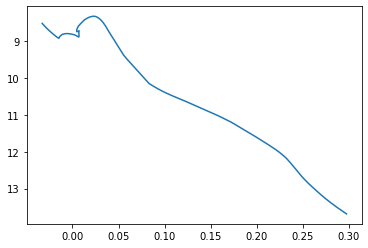

In [60]:
distance_modulus = 7.525 # to IC 348
plt.plot(
    lowmass_table['UKIDSS_H'] - lowmass_table['UKIDSS_K'], 
    lowmass_table['UKIDSS_K'] + distance_modulus)
plt.gca().invert_yaxis()

In [72]:
bd_variable_candidates = v_k > slope*v_hmk + y_intercept

print(variable_means[bd_variable_candidates])

plt.plot()

                    SOURCEID    MEANMJDOBS        RA       DEC    JMHPNT  \
SOURCEID                                                                   
44989782426682  4.498978e+13  56999.041061  0.978021  0.556121  0.891508   
44989782462202  4.498978e+13  56997.221425  0.973461  0.562612  0.667130   
44989782480405  4.498978e+13  56996.781159  0.985853  0.566682  0.366853   
44989782500630  4.498978e+13  56995.947112  0.980245  0.569040  0.861917   

                JMHPNTERR    HMKPNT  HMKPNTERR  JAPERMAG3  JAPERMAG3ERR  \
SOURCEID                                                                  
44989782426682   0.017731  0.481028   0.015121  16.176545      0.060265   
44989782462202   0.073865  0.280713   0.077164  17.775002      0.093592   
44989782480405   0.063682  0.177164   0.085873  17.601552      0.077450   
44989782500630   0.019921  0.295582   0.018964  16.313239      0.061224   

                HAPERMAG3  HAPERMAG3ERR  KAPERMAG3  KAPERMAG3ERR  JPPERRBITS  \
SOURCEID    

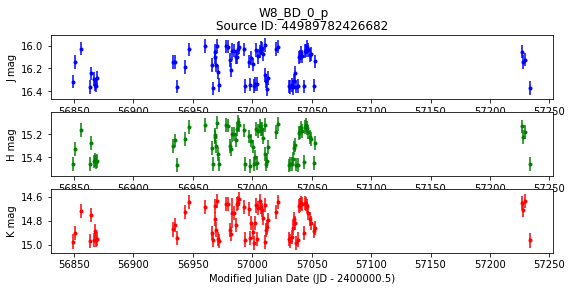

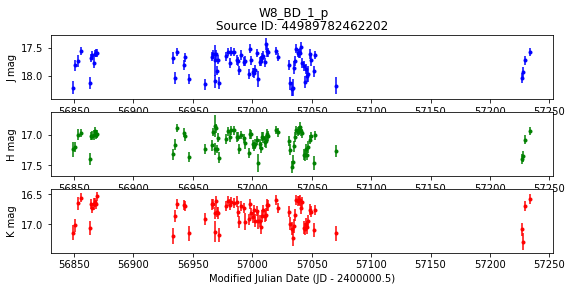

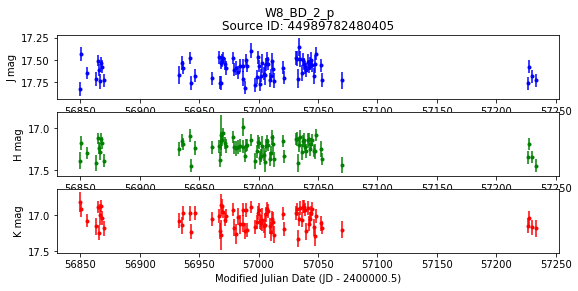

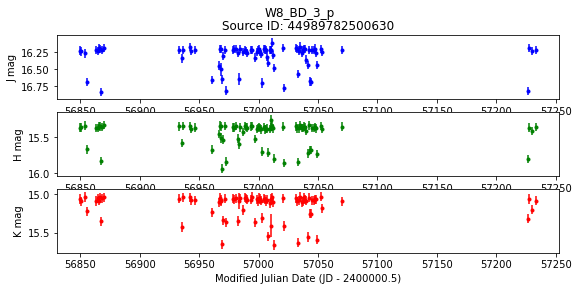

In [99]:
# let's look at their lightcurves
%run plots
for i, sid in enumerate(variable_means[bd_variable_candidates].index):
    three_plot(skimmed_df, sid)
#     print(f"v{i+1}")
    plt.suptitle(f'W8_BD_{i}_p')

Text(0, 0.5, 'DEC, radians')

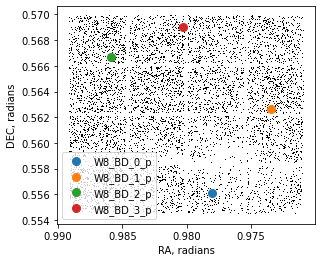

In [100]:
plt.plot(df_pure_medians['RA'], df_pure_medians['DEC'], 'k,')
for i, (ra, dec) in enumerate(zip(variable_means[bd_variable_candidates]['RA'], variable_means[bd_variable_candidates]['DEC'])):
    plt.plot(ra, dec, 'o', ms=8, label=f'W8_BD_{i}_p')
#plt.plot(variable_means[bd_variable_candidates]['RA'], variable_means[bd_variable_candidates]['DEC'], 'o')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title("")
ax.invert_xaxis()
plt.legend(loc='lower left')
ax.set_xlabel("RA, radians")
ax.set_ylabel("DEC, radians")

# plt.plot(df_pure.groupby("SOURCEID")['RA'].aggregate(np.mean).values, df_pure.groupby("SOURCEID")['DEC'].aggregate(np.mean).values, 'r,')
